# Orbit Fitting

In [125]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
import sys
sys.path.append('../code/')
import nbody_func as nbf


import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

import astropy.coordinates as coord
import astropy.units as u
from pyia import GaiaData


%matplotlib inline
rnd = np.random.RandomState(seed=42)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.mixture import GaussianMixture
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt


In [113]:
phi1_stream_pm_model = np.load('../data/phi1_stream_from_pm_model.npy')
stream_pm10 = np.load('../data/true_pm1_from_model.npy')
spline_pm1 = InterpolatedUnivariateSpline(phi1_stream_pm_model[::10], stream_pm10[::10])
stream_pm20 = np.load('../data/true_pm2_from_model.npy')
spline_pm2 = InterpolatedUnivariateSpline(phi1_stream_pm_model[::10], stream_pm20[::10])

est_track = np.load('../data/gd1_track.npy')
spline_phi2 = UnivariateSpline(phi1_stream_pm_model.reshape(est_track.shape)[::10], 
                                           est_track[::10])

phi1s = np.linspace(-100, 20, 120)

(-100.0, 20.0)

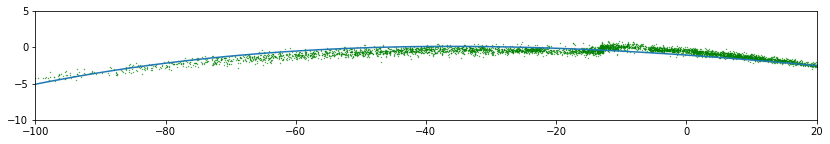

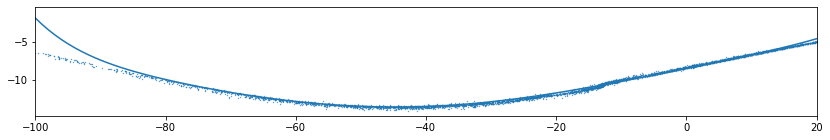

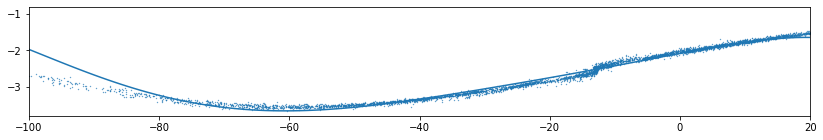

In [117]:
# my top choice and the one to use for the spur modeling
#creates the gaps around -20 and -5
df = ms.FardalStreamDF()
gd1 = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=-0.2*u.degree, distance=8.73*u.kpc,
                      pm_phi1_cosphi2=-10.62*u.mas/u.yr,
                      pm_phi2=-2.52*u.mas/u.yr,
                     radial_velocity = -185*u.km/u.s)
rep = gd1.transform_to(coord.Galactocentric).data
gd1_w0 = gd.PhaseSpacePosition(rep)
gd1_mass = 2e4 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
mw = gp.BovyMWPotential2014()
gen_gd1 = ms.MockStreamGenerator(df, mw, progenitor_potential=gd1_pot)
gd1_stream, _ = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=2500)
gd1_stream_c1 = gd1_stream.to_coord_frame(gc.GD1)

plt.figure(figsize=(14,2))
plt.scatter(gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, s=0.1, c='g')
plt.plot(phi1s, spline_phi2(phi1s))
plt.xlim(-100,20)
plt.ylim(-10, 5)

plt.figure(figsize=(14,2))
plt.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi1_cosphi2, s=0.1)
plt.plot(phi1s, spline_pm1(phi1s))
plt.xlim(-100,20)

plt.figure(figsize=(14,2))
plt.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi2, s=0.1)
plt.plot(phi1s, spline_pm2(phi1s))
plt.xlim(-100,20)

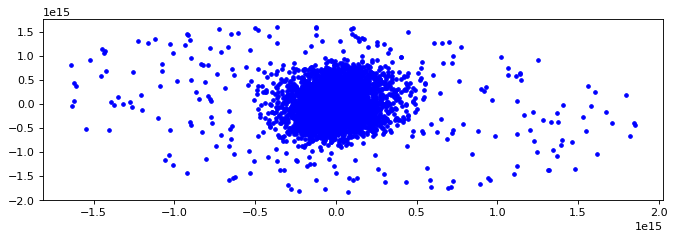

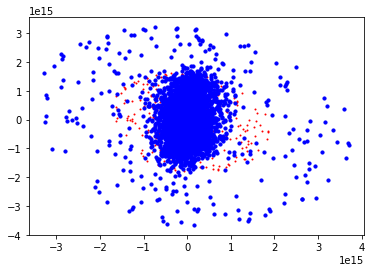

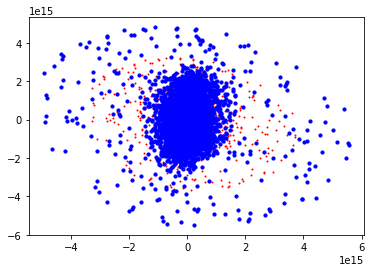

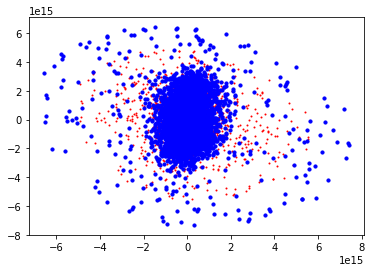

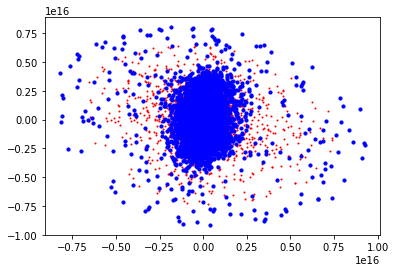

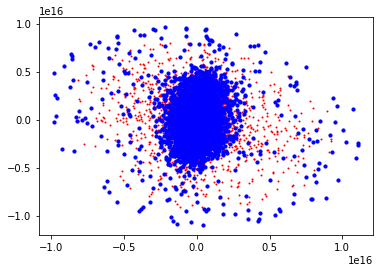

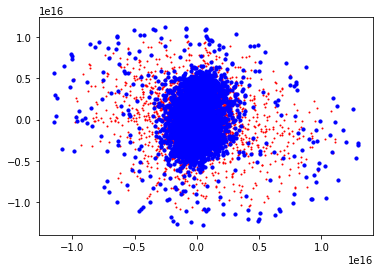

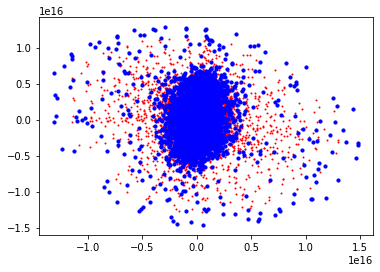

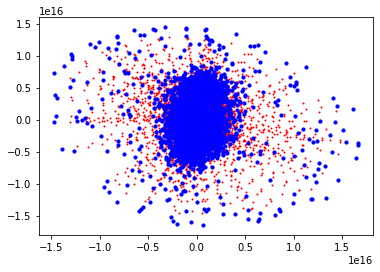

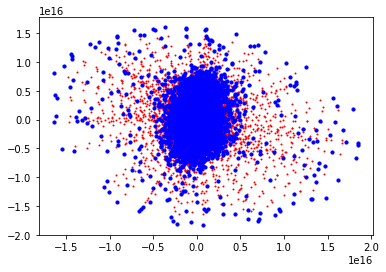

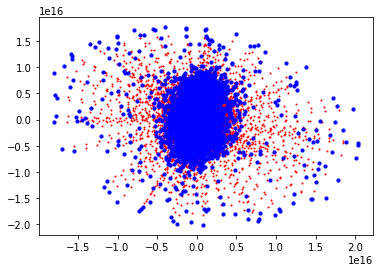

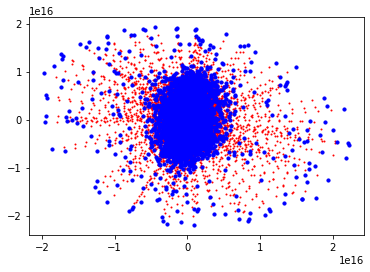

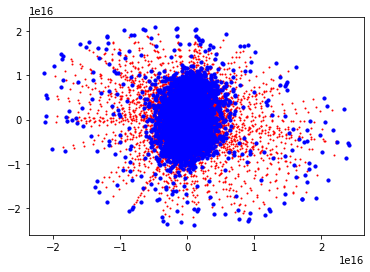

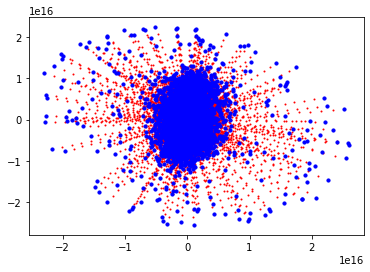

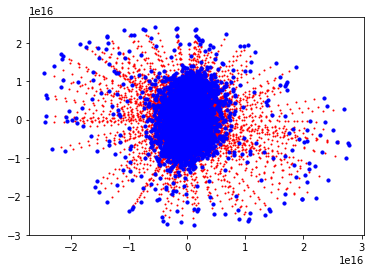

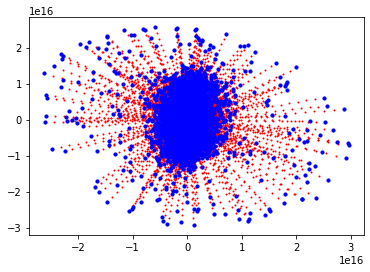

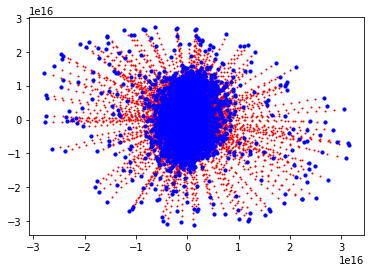

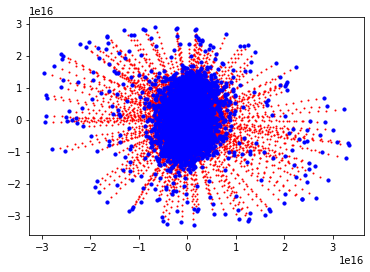

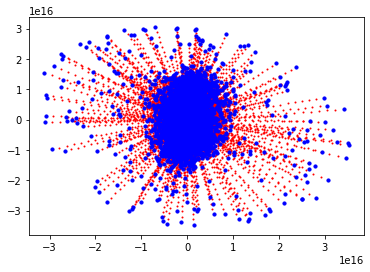

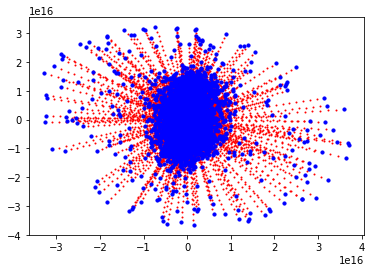

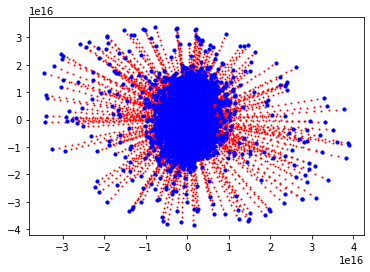

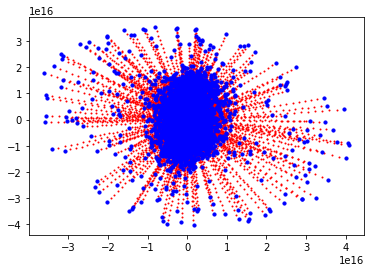

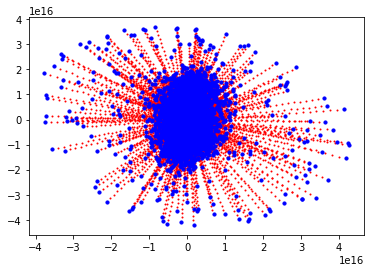

KeyboardInterrupt: 

In [140]:
""" N-body simulation """

# Simulation parameters
N         = len(gd1_stream_c1)    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 3e9   # time at which simulation ends
dt        = 1e6   # timestep
softening = 0.1    # softening length
G         = 1.0    # Newton's Gravitational Constant
plotRealTime = True # switch on for plotting as the simulation goes along

# Generate Initial Conditions
np.random.seed(17)            # set the random number generator seed

mass = 2e4*np.ones((N,1))/N  # total mass of particles is 20
pos  = np.vstack([gd1_stream_c1.phi1.value, 
                  gd1_stream_c1.phi2.value, 
                  gd1_stream_c1.distance.value]).T #in deg, deg, parsecs
vel  = np.vstack([gd1_stream_c1.pm_phi1_cosphi2.value/(1000*3600*3600*24*365), # in deg/sec
                  gd1_stream_c1.pm_phi2.value/(1000*3600*3600*24*365), # in deg/sec
                  gd1_stream_c1.radial_velocity.value * 3.24e-17]).T # in parsec/sec

# Convert to Center-of-Mass frame
vel -= np.mean(mass * vel,0) / np.mean(mass)

# calculate initial gravitational accelerations
acc = nbf.getAcc( pos, mass, G, softening )

# calculate initial energy of system
KE, PE  = nbf.getEnergy( pos, vel, mass, G )

# number of timesteps
Nt = int(np.ceil(tEnd/dt))

# save energies, particle orbits for plotting trails
pos_save = np.zeros((N,3,Nt+1))
pos_save[:,:,0] = pos
KE_save = np.zeros(Nt+1)
KE_save[0] = KE
PE_save = np.zeros(Nt+1)
PE_save[0] = PE
t_all = np.arange(Nt+1)*dt

# prep figure
fig = plt.figure(figsize=(10,3), dpi=80)

# Simulation Main Loop
for i in range(Nt):
    # (1/2) kick
    vel += acc * dt/2.0

    # drift
    pos += vel * dt

    # update accelerations
    acc = nbf.getAcc( pos, mass, G, softening )

    # (1/2) kick
    vel += acc * dt/2.0

    # update time
    t += dt

    # get energy of system
    KE, PE  = nbf.getEnergy( pos, vel, mass, G )

    # save energies, positions for plotting trail
    pos_save[:,:,i+1] = pos
    KE_save[i+1] = KE
    PE_save[i+1] = PE

    # plot in real time
    if plotRealTime or (i == Nt-1):
        xx = pos_save[:,0,max(i-50,0):i+1]
        yy = pos_save[:,1,max(i-50,0):i+1]
        plt.scatter(xx,yy,s=1, c='r')
        plt.scatter(pos[:,0],pos[:,1],s=10,color='blue')
        #plt.xlim(-100, 20); plt.ylim=(-10, 5)
        #ax1.set_aspect('equal', 'box')
        #plt.xticks([-100, -80, -60, -40, -20, 0, 20])
        #plt.yticks([-10,-7,-4,-1,2, 5])

        plt.pause(0.001)


plt.show()

(-100.0, 20.0)

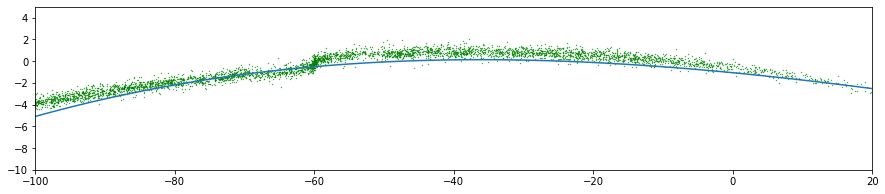

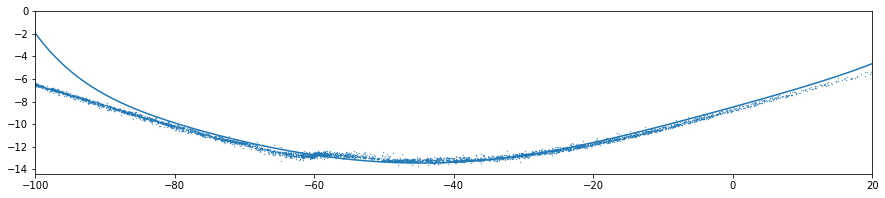

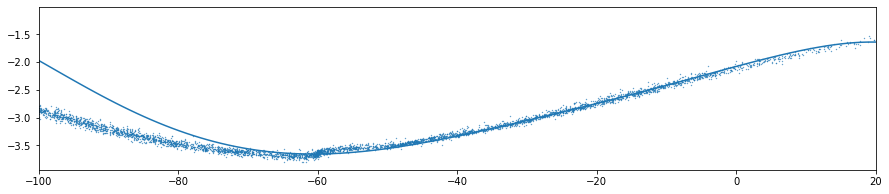

In [116]:
#creates the sharp decline in density around phi1=-60
df = ms.FardalStreamDF(lead=True)
gd1 = gc.GD1Koposov10(phi1 = -60*u.degree, phi2=-0.2*u.degree, distance=7.30*u.kpc,
                      pm_phi1_cosphi2=-12.73*u.mas/u.yr,
                      pm_phi2=-3.64*u.mas/u.yr,
                     radial_velocity = 130*u.km/u.s)
rep = gd1.transform_to(coord.Galactocentric).data
gd1_w0 = gd.PhaseSpacePosition(rep)
gd1_mass = 2e4 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
mw = gp.BovyMWPotential2014()
gen_gd1 = ms.MockStreamGenerator(df, mw, progenitor_potential=gd1_pot)
gd1_stream, _ = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=2500)
gd1_stream_c1 = gd1_stream.to_coord_frame(gc.GD1)

plt.figure(figsize=(15,3))
plt.scatter(gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, s=0.1, c='g')
plt.plot(phi1s, spline_phi2(phi1s))
plt.xlim(-100,20)
plt.ylim(-10, 5)

plt.figure(figsize=(15,3))
plt.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi1_cosphi2, s=0.1)
plt.plot(phi1s, spline_pm1(phi1s))
plt.xlim(-100,20)

plt.figure(figsize=(15,3))
plt.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi2, s=0.1)
plt.plot(phi1s, spline_pm2(phi1s))
plt.xlim(-100,20)

In [118]:
gd1_stream_c1

<GD1Koposov10 Coordinate: (phi1, phi2, distance) in (deg, deg, kpc)
    [( 27.28047843, -3.53321848, 14.65303239),
     (-66.69931094, -1.35034499,  7.64242892),
     ( 39.14153309, -5.4224338 , 17.90996378), ...,
     (-12.77984549, -0.48570547,  8.64674929),
     (-13.32867264,  0.34260703,  8.85752289),
     (-12.87722201, -0.39272942,  8.68371098)]
 (pm_phi1_cosphi2, pm_phi2, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( -4.04459095, -1.35378069, -347.28356636),
     (-11.94257769, -3.50016265,  174.03170283),
     ( -2.65721539, -1.15736138, -354.22596142), ...,
     (-10.67521825, -2.56200423, -185.81315169),
     (-10.50847506, -2.44108252, -183.74992002),
     (-10.67216095, -2.56191656, -185.40898344)]>

In [131]:
pos = np.vstack([gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, gd1_stream_c1.distance.value]).T

In [132]:
pos[:,0]

array([ 27.28047843, -66.69931094,  39.14153309, ..., -12.77984549,
       -13.32867264, -12.87722201])

In [133]:
pos

array([[ 27.28047843,  -3.53321848,  14.65303239],
       [-66.69931094,  -1.35034499,   7.64242892],
       [ 39.14153309,  -5.4224338 ,  17.90996378],
       ...,
       [-12.77984549,  -0.48570547,   8.64674929],
       [-13.32867264,   0.34260703,   8.85752289],
       [-12.87722201,  -0.39272942,   8.68371098]])